# Salesforce LLM Model - Moirai


Moirai, the Masked Encoder-based Universal Time Series Forecasting Transformer is a Large Time Series Model pre-trained on LOTSA data.

Overall Architecture of Moirai:

<img src="../img/Moirai.png" alt="moirai model" width=800>


The model can be implemented using the *Unified Training of Universal Time Series Transformers*. Uni2TS is a PyTorch based library for research and applications related to Time Series Forecasting. It provides a unified framework for large-scale pre-training, fine-tuning, inference, and evaluation of Universal Time Series Transformers. [ref](https://github.com/SalesforceAIResearch/uni2ts)

Installation: 

```bash
git clone https://github.com/SalesforceAIResearch/uni2ts.git
cd uni2ts
python -m venv .venv
source .venv/bin/activate
pip install -e '.[notebook]'
```

### Prediction Logic 

[Ref](https://github.com/SalesforceAIResearch/uni2ts/blob/main/example/moirai_forecast_pandas.ipynb)

Given a time series, Moirai (prediction model) use the context window as input and outputs a prediction window. So, the user need to set the context_length and prediction_length in advance.

For time series data, the information contained within a single timestamp is not rich enough. Therefore, we refer to consecutive time points as 'patches', forming the basic units of Moirai input (similar to the concept of word token in Language Models). Moirai provides various patch_size [8, 16, 32, 64, 128].

Additionally, users need to select the model size ('small', 'base', 'large') of Moirai for prediction, along with the batch_size, which determines the number of samples that can be inferred in parallel. Since Moirai supports probablistic forecast, users should specify the num_samples, indicating the number of times it has to sample the forecasting distribution



<img src="../img/Moirai_prediction.png" alt="moirai model" width=800>




In [3]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

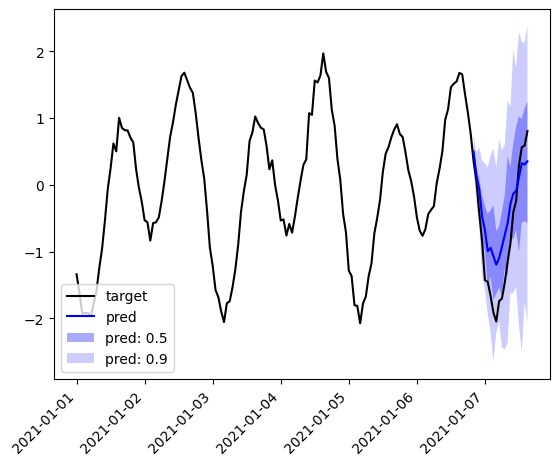

In [4]:
MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 20  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 100  # test set length: any positive integer

# Read data into pandas DataFrame
url = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)

# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

# Prepare pre-trained model by downloading model weights from huggingface hub
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-{SIZE}"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

plot_single(
    inp, 
    label, 
    forecast, 
    context_length=200,
    name="pred",
    show_label=True,
)
plt.show()

# Amazon Model Chronos

Chronos is a family of pretrained time series forecasting models based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss. Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes. [ref](https://huggingface.co/amazon/chronos-t5-large)

High Level Description of Chronos: 

<img src="../img/chronos.png" alt="chronos model" width=800>


Installation:

```bash
pip install git+https://github.com/amazon-science/chronos-forecasting.git
```


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

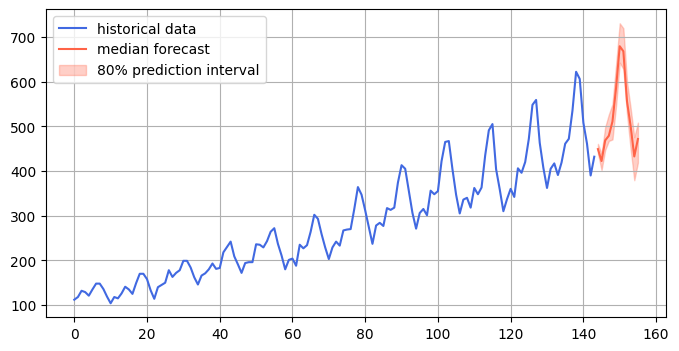

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-base",
  device_map="mps",
  torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()
